In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from sympy import Matrix
import matplotlib.pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings("ignore")

### Draper Adder Scheme from https://arxiv.org/pdf/1411.5949.pdf

The idea of Draper adder implemented is the following: 
- Apply QFT on the zero initialized result register
- Use controlled Phase rotations as per the Draper scheme with one of the number register as control
- Do inverse QFT to reach the original space and do measurements


In [2]:
def qft_rotations(circuit, n):
    """Add controlled phase gates as per qft on the first n qubits in circuit"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n) # recursion call
    
def swap_registers(circuit, n):
    """Swap Registers as per QFT scheme"""
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [3]:
def draper_scheme_iter(a_idx, b_idx, n, scale_factor=0):
    """Performs Draper Scheme on the a with b, both numbers of n.
    Additionaly scale factor is considered for Multiplier circuits"""
    circuit = QuantumCircuit(a_idx + 1, name="Draper_adder")
    # Iteration based approach to implement Draper addition
    for a_qubit in range(b_idx + 1, a_idx + 1):
        for b_qubit in range(0, b_idx + 1):
            exp = a_qubit - b_idx - 1 + b_qubit + 1 - n
            if exp < 0:
                continue
            circuit.cp((np.pi/2**(a_qubit - b_idx - 1 + b_qubit + 1 - n)) * (2 ** scale_factor), b_qubit, a_qubit)
    return circuit

In [4]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose()

#### An adder Example

In [5]:
a = 8
b = 3
n = (len(bin(b)) - 2) if len(bin(b)) >= len(bin(a)) else (len(bin(a)) - 2)
a_bin = np.binary_repr(a, width=n)
b_bin = np.binary_repr(b, width=n)
a_bin, b_bin, n

('1000', '0011', 4)

In [6]:
a_arr, b_arr = list(a_bin), list(b_bin)
a_arr, b_arr

(['1', '0', '0', '0'], ['0', '0', '1', '1'])

In [7]:
q = QuantumRegister(2*n + 1)
qc = QuantumCircuit(q)
for i in range(n):
    if b_arr[i] == '1':
        qc.x(i)
for i in range(n):
    if a_arr[i] == '1':
        qc.x(n + 1 + i)
qft_circ = qft(QuantumCircuit(n+1, name="QFT"), n+1)

qc.barrier()
qc.append(qft_circ, q[2*n:n-1:-1])
qc.barrier()

In [8]:
qc.append(draper_scheme_iter(2*n, n-1,n), q[:])
qc.barrier()

In [9]:
inv_qft = inverse_qft(QuantumCircuit(n+1, name="INV_QFT"), n+1)
qc.append(inv_qft.to_instruction(), q[2*n:n-1:-1])
qc.measure_all()
qc.draw()

░          ░ ┌───────────────┐ ░              ░ ┌─┐            »
  q0_0: ──────░──────────░─┤0              ├─░──────────────░─┤M├────────────»
              ░          ░ │               │ ░              ░ └╥┘┌─┐         »
  q0_1: ──────░──────────░─┤1              ├─░──────────────░──╫─┤M├─────────»
        ┌───┐ ░          ░ │               │ ░              ░  ║ └╥┘┌─┐      »
  q0_2: ┤ X ├─░──────────░─┤2              ├─░──────────────░──╫──╫─┤M├──────»
        ├───┤ ░          ░ │               │ ░              ░  ║  ║ └╥┘┌─┐   »
  q0_3: ┤ X ├─░──────────░─┤3              ├─░──────────────░──╫──╫──╫─┤M├───»
        └───┘ ░ ┌──────┐ ░ │               │ ░ ┌──────────┐ ░  ║  ║  ║ └╥┘┌─┐»
  q0_4: ──────░─┤4     ├─░─┤4 Draper_adder ├─░─┤4         ├─░──╫──╫──╫──╫─┤M├»
        ┌───┐ ░ │      │ ░ │               │ ░ │          │ ░  ║  ║  ║  ║ └╥┘»
  q0_5: ┤ X ├─░─┤3     ├─░─┤5              ├─░─┤3         ├─░──╫──╫──╫──╫──╫─»
        └───┘ ░ │      │ ░ │               │ ░ │          │ ░  ║  ║  ║  ║  ║ »
  q0_6: ──────░─┤2 QFT ├─░─┤6              ├─░─┤2 INV_QFT ├─░──╫──╫──╫──╫──╫─»
              ░ │      │ ░ │               │ ░ │          │ ░  ║  ║  ║  ║  ║ »
  q0_7: ──────░─┤1     ├─░─┤7              ├─░─┤1         ├─░──╫──╫──╫──╫──╫─»
              ░ │      │ ░ │               │ ░ │          │ ░  ║  ║  ║  ║  ║ »
  q0_8: ──────░─┤0     ├─░─┤8              ├─░─┤0         ├─░──╫──╫──╫──╫──╫─»
              ░ └──────┘ ░ └───────────────┘ ░ └──────────┘ ░  ║  ║  ║  ║  ║ »
meas: 9/═══════════════════════════════════════════════════════╩══╩══╩══╩══╩═»
                                                               0  1  2  3  4 »
«                    
«  q0_0: ────────────
«                    
«  q0_1: ────────────
«                    
«  q0_2: ────────────
«                    
«  q0_3: ────────────
«                    
«  q0_4: ────────────
«        ┌─┐         
«  q0_5: ┤M├─────────
«        └╥┘┌─┐      
«  q0_6: ─╫─┤M├──────
«         ║ └╥┘┌─┐   
«  q0_7: ─╫──╫─┤M├───
«         ║  ║ └╥┘┌─┐
«  q0_8: ─╫──╫──╫─┤M├
«         ║  ║  ║ └╥┘
«meas: 9/═╩══╩══╩══╩═
«         5  6  7  8

{'110101100': 10000}


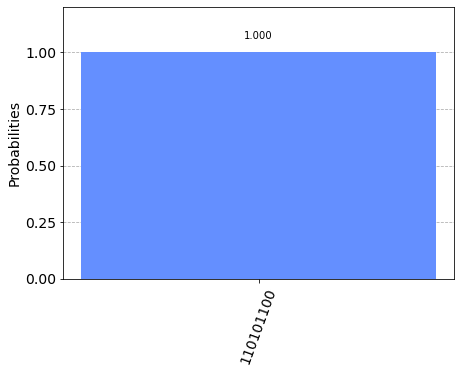

In [10]:
qc = qc.decompose()
shots = 10000 ## Most accurate high number of shots
sim = Aer.get_backend('qasm_simulator')
qobj = assemble(qc)
result_counts = sim.run(qobj, shots = shots).result().get_counts()
print(result_counts)
plot_histogram(result_counts)

In [11]:
fin_max = max(result_counts, key=result_counts.get)
print("The sum of a:{} and b:{} is {}".format(a,b, int((fin_max[n::-1]),2)))

The sum of a:8 and b:3 is 11


### QFT Multiplier

In [12]:
def sub_adder(n, scale):
    """Draper Adder Circuit for Multiplier Sub-blocks with a certain phase scale factor"""
    circuit = QuantumCircuit(3*n, name="Drap_adder, 2^{}".format(scale))
    circuit.append(draper_scheme_iter(3*n-1, n-1, n,scale_factor=scale), circuit.qubits[:])
    return circuit.decompose()

#####  A Multiplication Example

In [13]:
a = 5
b = 6
n = (len(bin(b)) - 2) if len(bin(b)) >= len(bin(a)) else (len(bin(a)) - 2)
a_bin = np.binary_repr(a, width=n)
b_bin = np.binary_repr(b, width=n)
a_arr, b_arr = list(a_bin), list(b_bin)
a_arr, b_arr

(['1', '0', '1'], ['1', '1', '0'])

In [14]:
q = QuantumRegister(4*n)
qc = QuantumCircuit(q)
for i in range(n):
    if b_arr[i] == '1':
        qc.x(i)
for i in range(n):
    if a_arr[i] == '1':
        qc.x(n + i)
qft_circ = qft(QuantumCircuit(2*n, name="QFT"), 2*n)

qc.barrier()
qc.append(qft_circ, q[4*n:2*n-1:-1])
qc.barrier()

In [15]:
for i in range(n):
    subadder_now = sub_adder(n, i).control(1)
    qc.append(subadder_now,  [q[n-1-i]] + q[n:])

In [16]:
qc.barrier()
inv_qft = inverse_qft(QuantumCircuit(2*n, name="INV_QFT"), 2*n)
qc.append(inv_qft.to_instruction(), q[4*n:2*n-1:-1])

qc.measure_all()
qc.draw(scale=0.5)

┌───┐ ░          ░                                             »
   q1_0: ┤ X ├─░──────────░─────────────────────────────────────────────»
         ├───┤ ░          ░                       ┌────────────────────┐»
   q1_1: ┤ X ├─░──────────░───────────────────────┤0                   ├»
         └───┘ ░          ░ ┌────────────────────┐│                    │»
   q1_2: ──────░──────────░─┤0                   ├┤                    ├»
         ┌───┐ ░          ░ │                    ││                    │»
   q1_3: ┤ X ├─░──────────░─┤1                   ├┤1                   ├»
         └───┘ ░          ░ │                    ││                    │»
   q1_4: ──────░──────────░─┤2                   ├┤2                   ├»
         ┌───┐ ░          ░ │                    ││                    │»
   q1_5: ┤ X ├─░──────────░─┤3                   ├┤3                   ├»
         └───┘ ░ ┌──────┐ ░ │                    ││                    │»
   q1_6: ──────░─┤5     ├─░─┤4                   ├┤4 c_Drap_adder, 2^1 ├»
               ░ │      │ ░ │  c_Drap_adder, 2^0 ││                    │»
   q1_7: ──────░─┤4     ├─░─┤5                   ├┤5                   ├»
               ░ │      │ ░ │                    ││                    │»
   q1_8: ──────░─┤3     ├─░─┤6                   ├┤6                   ├»
               ░ │  QFT │ ░ │                    ││                    │»
   q1_9: ──────░─┤2     ├─░─┤7                   ├┤7                   ├»
               ░ │      │ ░ │                    ││                    │»
  q1_10: ──────░─┤1     ├─░─┤8                   ├┤8                   ├»
               ░ │      │ ░ │                    ││                    │»
  q1_11: ──────░─┤0     ├─░─┤9                   ├┤9                   ├»
               ░ └──────┘ ░ └────────────────────┘└────────────────────┘»
meas: 12/═══════════════════════════════════════════════════════════════»
                                                                        »
«         ┌────────────────────┐ ░              ░ ┌─┐                        »
«   q1_0: ┤0                   ├─░──────────────░─┤M├────────────────────────»
«         │                    │ ░              ░ └╥┘┌─┐                     »
«   q1_1: ┤                    ├─░──────────────░──╫─┤M├─────────────────────»
«         │                    │ ░              ░  ║ └╥┘┌─┐                  »
«   q1_2: ┤                    ├─░──────────────░──╫──╫─┤M├──────────────────»
«         │                    │ ░              ░  ║  ║ └╥┘┌─┐               »
«   q1_3: ┤1                   ├─░──────────────░──╫──╫──╫─┤M├───────────────»
«         │                    │ ░              ░  ║  ║  ║ └╥┘┌─┐            »
«   q1_4: ┤2                   ├─░──────────────░──╫──╫──╫──╫─┤M├────────────»
«         │                    │ ░              ░  ║  ║  ║  ║ └╥┘┌─┐         »
«   q1_5: ┤3                   ├─░──────────────░──╫──╫──╫──╫──╫─┤M├─────────»
«         │  c_Drap_adder, 2^2 │ ░ ┌──────────┐ ░  ║  ║  ║  ║  ║ └╥┘┌─┐      »
«   q1_6: ┤4                   ├─░─┤5         ├─░──╫──╫──╫──╫──╫──╫─┤M├──────»
«         │                    │ ░ │          │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   »
«   q1_7: ┤5                   ├─░─┤4         ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├───»
«         │                    │ ░ │          │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐»
«   q1_8: ┤6                   ├─░─┤3         ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├»
«         │                    │ ░ │  INV_QFT │ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘»
«   q1_9: ┤7                   ├─░─┤2         ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
«         │                    │ ░ │          │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
«  q1_10: ┤8                   ├─░─┤1         ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
«         │                    │ ░ │          │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
«  q1_11: ┤9                   ├─░─┤0         ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
«         └────────────────────┘ ░ └──────────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
«meas: 12/══════════════════════════

{'011110101011': 10000}


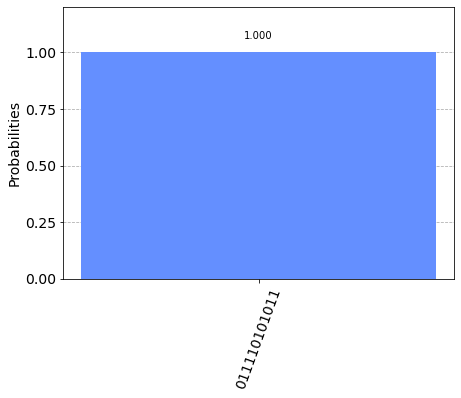

In [17]:
qc = qc.decompose(reps=2) # Decomposition necessary to run in simulators
shots = 10000 ## Most accurate high number of shots
sim = Aer.get_backend('qasm_simulator')
qobj = assemble(qc)
result_counts = sim.run(qobj, shots = shots).result().get_counts()
print(result_counts)
plot_histogram(result_counts)

In [18]:
fin_max = max(result_counts, key=result_counts.get)
print("The Product of a:{} and b:{} is {} , While real product is {}, Validity:{}".
      format(a,b, int((fin_max[2*n-1::-1]),2), a*b, a*b == int((fin_max[2*n-1::-1]),2)))

The Product of a:5 and b:6 is 30 , While real product is 30, Validity:True


##### Multiplier Function

In [19]:
def multiplier(a, b, sim_string='aer_simulator', mem_usage=False):
    """
    Performs multiplication of positive integers a and b through a
    Quantum Scheme and sim_string define the simulator to be used 
    for running the circuit experiments 
    
    """
    n = (len(bin(b)) - 2) if len(bin(b)) >= len(bin(a)) else (len(bin(a)) - 2)
    a_bin = np.binary_repr(a, width=n)
    b_bin = np.binary_repr(b, width=n)
    a_arr, b_arr = list(a_bin), list(b_bin)
    
    q = QuantumRegister(4*n)
    qc = QuantumCircuit(q)
    
    for i in range(n):
        if b_arr[i] == '1':
            qc.x(i)
    for i in range(n):
        if a_arr[i] == '1':
            qc.x(n + i)
    qft_circ = qft(QuantumCircuit(2*n), 2*n)

    qc.barrier()
    qc.append(qft_circ, q[4*n:2*n-1:-1])
    qc.barrier()
    
    for i in range(n):
        subadder_now = sub_adder(n, i).control(1)
        qc.append(subadder_now,  [q[n-1-i]] + q[n:])
    
    qc.barrier()
    inv_qft = inverse_qft(QuantumCircuit(2*n), 2*n)
    qc.append(inv_qft.to_instruction(), q[4*n:2*n-1:-1])
    qc = qc.decompose(reps=2)
    qc.measure_all()

    shots = 10000 
    sim = Aer.get_backend(sim_string)
    qobj = assemble(qc)
    result = sim.run(qobj, shots = shots, memory=mem_usage).result()
    result_counts = result.get_counts()
    fin_max = max(result_counts, key=result_counts.get)
    
    if mem_usage:
        memory = result.get_memory(qobj)
        print(memory)
    
    return int((fin_max[2*n-1::-1]),2)  

###### Verification of multiplication working on random inputs

In [20]:
from random import *
valid = 0
testcases = 20
for i in range(testcases):
    a = randint(0,50)
    b = randint(0,50)
    circuit_out = multiplier(a, b)
    print("a:{}, b:{}, Actual Product :: {} , Circuit Output Product :: {}, Validity : {}".format(a, b,
        a*b, circuit_out, a*b == circuit_out))
    if  a*b == circuit_out : valid += 1
print("Validity: {}/{}, percent: {} %".format(valid, testcases, (valid/testcases) * 100))

a:44, b:20, Actual Product :: 880 , Circuit Output Product :: 880, Validity : True
a:28, b:38, Actual Product :: 1064 , Circuit Output Product :: 1064, Validity : True
a:19, b:17, Actual Product :: 323 , Circuit Output Product :: 323, Validity : True
a:45, b:23, Actual Product :: 1035 , Circuit Output Product :: 1035, Validity : True
a:44, b:13, Actual Product :: 572 , Circuit Output Product :: 572, Validity : True
a:37, b:14, Actual Product :: 518 , Circuit Output Product :: 518, Validity : True
a:25, b:19, Actual Product :: 475 , Circuit Output Product :: 475, Validity : True
a:36, b:13, Actual Product :: 468 , Circuit Output Product :: 468, Validity : True
a:32, b:49, Actual Product :: 1568 , Circuit Output Product :: 1568, Validity : True
a:37, b:19, Actual Product :: 703 , Circuit Output Product :: 703, Validity : True
a:23, b:7, Actual Product :: 161 , Circuit Output Product :: 161, Validity : True
a:36, b:22, Actual Product :: 792 , Circuit Output Product :: 792, Validity : True

##### Comparison of subroutine time performances via profiling
For  this we use Cprofile package and its results can be visualized using gprof2dot package.
An example of the profiling graph, as visualized using the gprof2dot package looks similar to the image attached below. 

The things to consider while looking at the graph are as follows :     


*   Each block has colour shade from blue, all the way towards red. The closer the shade towards red, the more time consumption it takes at a given level.
*   Each block has 4 rows of information.
  1. Describes the function.
  2. '%' of the consumption within a given level.
  3. '%' of the total consumption over the entire profiled function.
  4. Number of times the call was made to that function. 

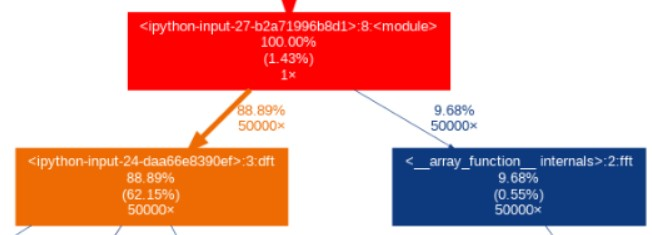




In [21]:
import gprof2dot
import cProfile as profile

In [22]:
Aer.backends() # Available Simulator backends

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [23]:
a = randint(0,50)
b = randint(0,50)
runs = 100
profile_result_file = 'Multiplier_profiler.pstat'
pr = profile.Profile()
pr.enable()
for _ in range(runs):
    aer_sim_out = multiplier(a, b, sim_string=Aer.backends()[0].__str__())
pr.disable()
pr.dump_stats(f'./{profile_result_file}')

In [24]:
!gprof2dot -f pstats Multiplier_profiler.pstat | dot -Tpng -o output.png

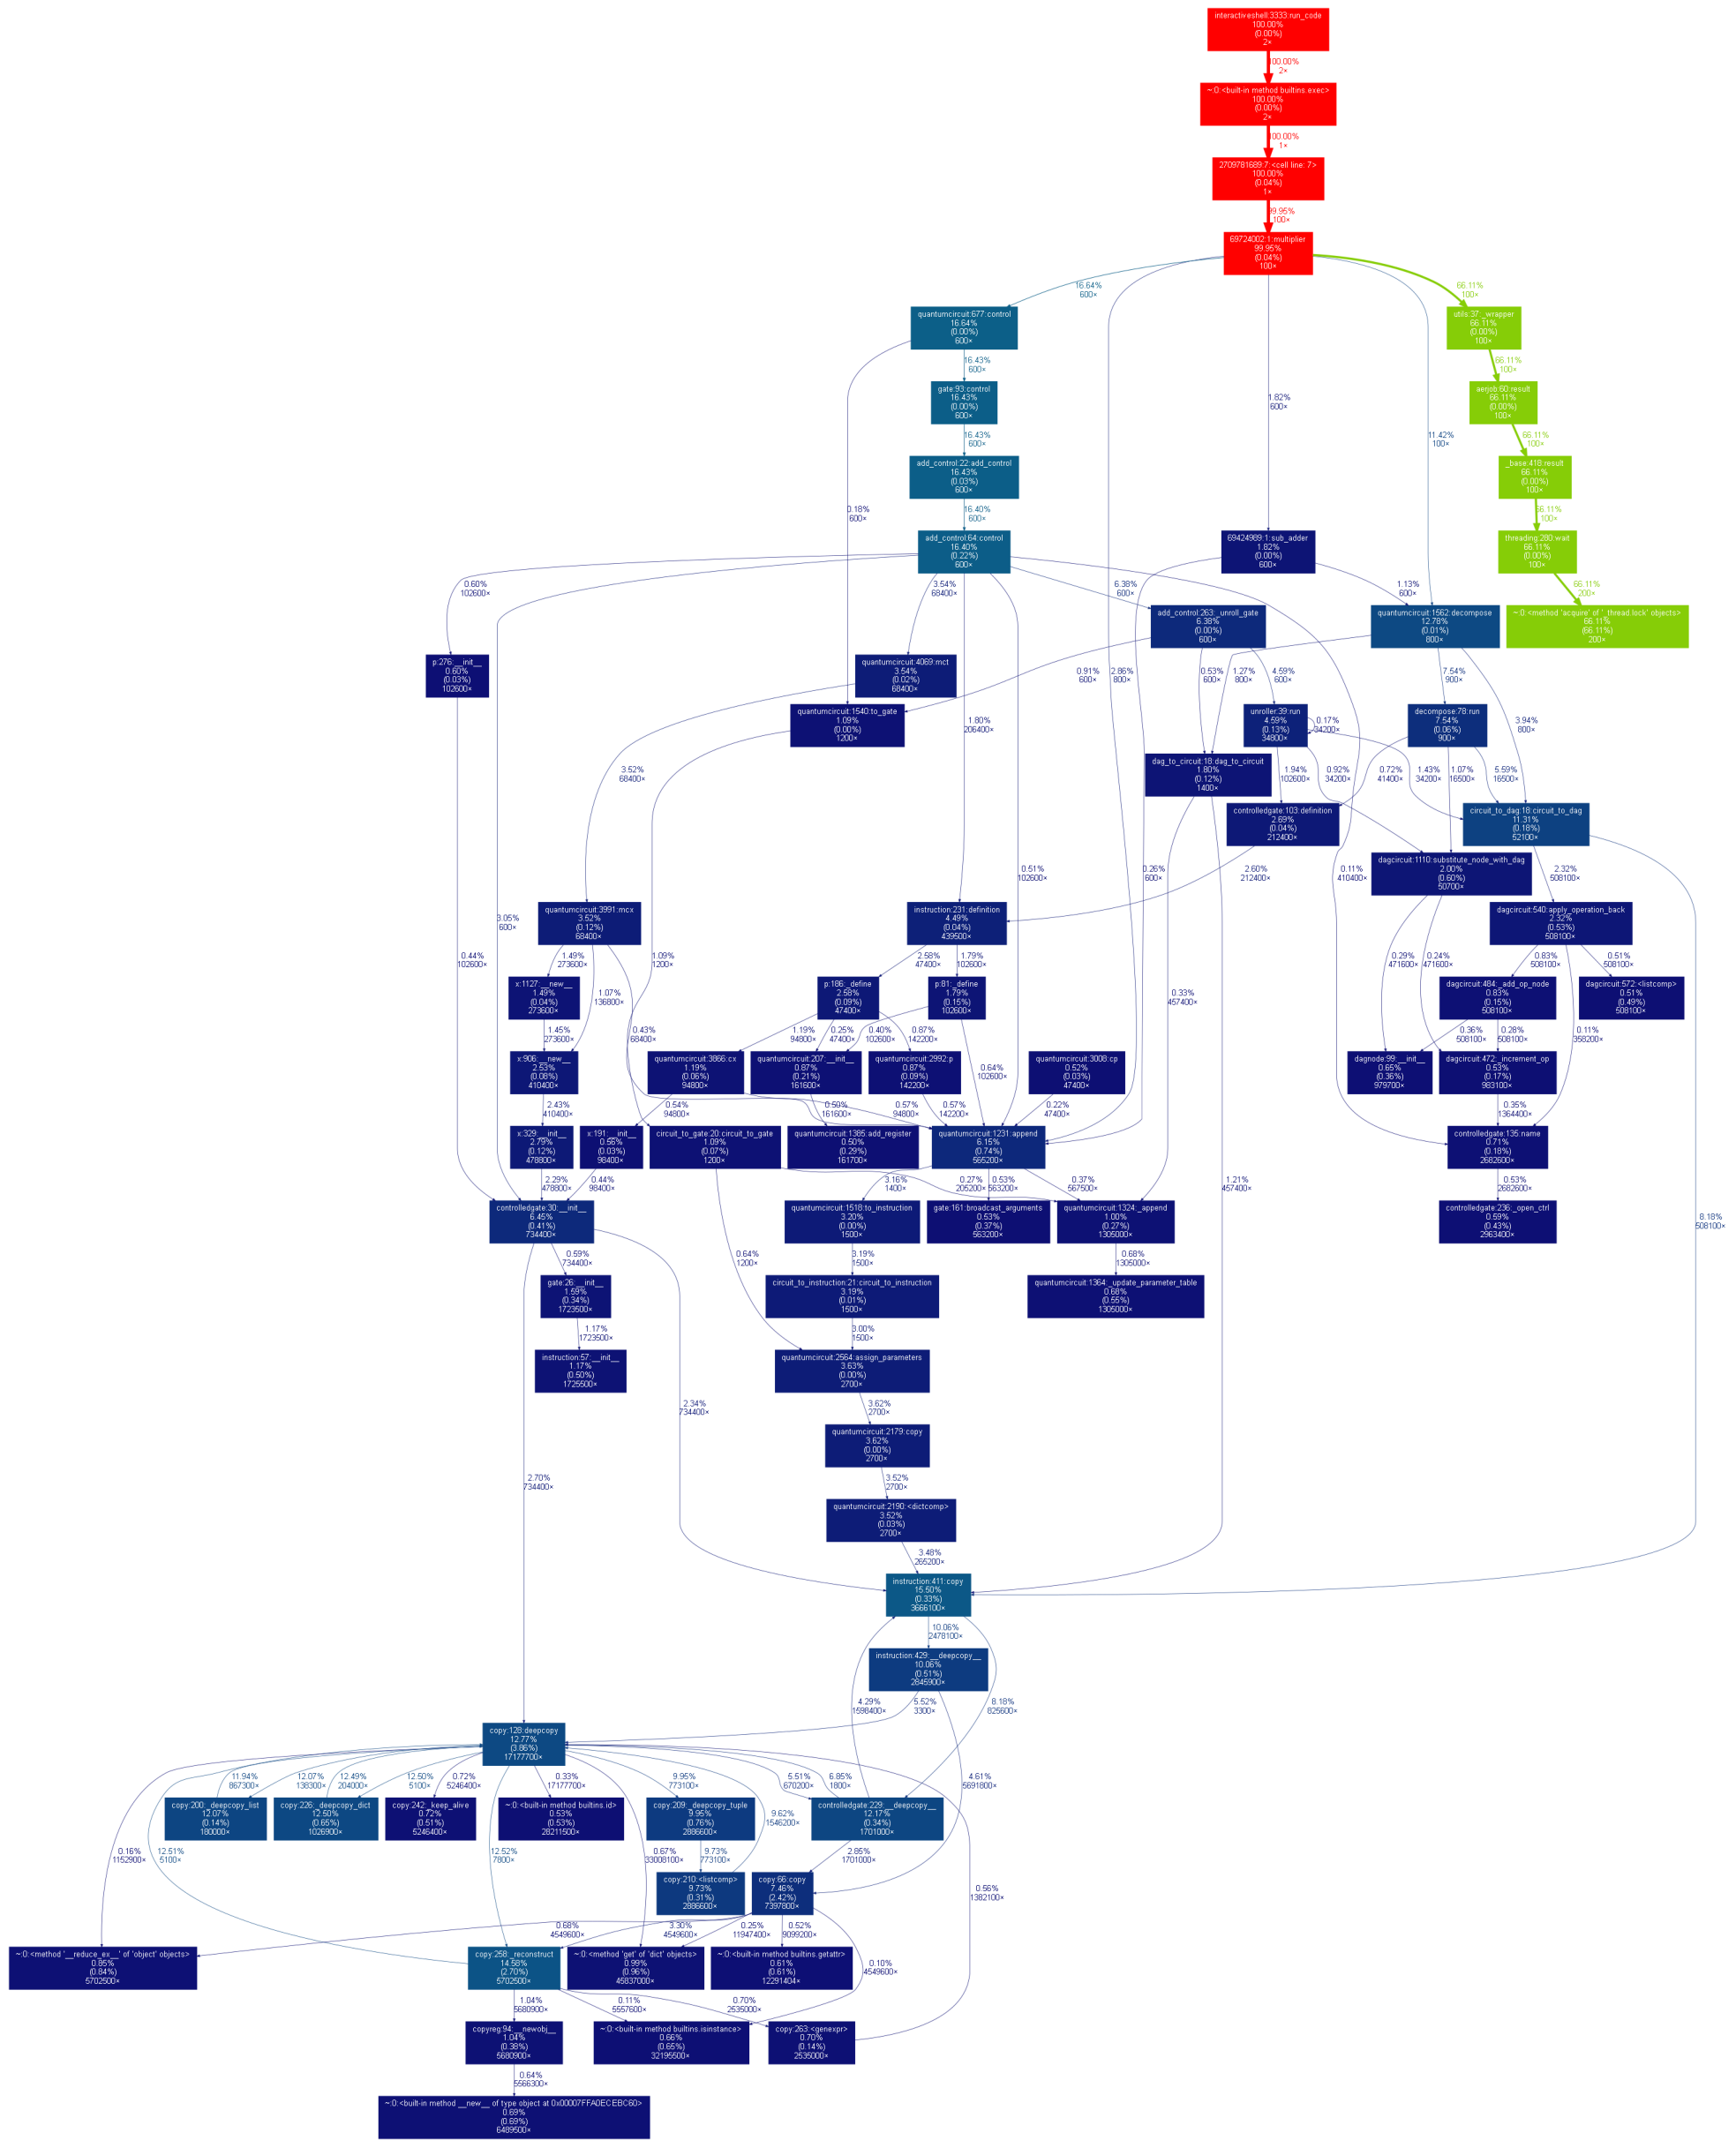

In [25]:
import skimage.io
I = skimage.io.imread(r"output.png")

plt.figure(figsize=(35,60))
plt.imshow(I)
plt.axis("off")
plt.show()

##### Different Simulator TIme performance using time module

In [26]:
a = randint(0,10)
b = randint(0,10)

import time

runs = 200
timenow = time.time() 
for _ in range(runs):
    aer_sim_out = multiplier(a, b, sim_string=Aer.backends()[0].__str__())
time_aer = (time.time() - timenow)/runs

timenow = time.time() 
for _ in range(runs):
    state_sim_out = multiplier(a, b, sim_string=Aer.backends()[1].__str__())
time_state = (time.time() - timenow)/runs

timenow = time.time() 
for _ in range(runs):
    qasm_sim_out = multiplier(a, b, sim_string=Aer.backends()[8].__str__())
time_qasm= (time.time() - timenow)/runs
print("a: {}, b:{}, product:{}".format(a, b, aer_sim_out))
print("Average time taken ::: \n\n aer_simulator:{} secs ;\n\n state_vector:{} secs;\n\n qasm_sim:{} secs"
      .format(time_aer, time_state,time_qasm))

a: 5, b:7, product:35
Average time taken ::: 

 aer_simulator:0.21651052832603454 secs ;

 state_vector:0.22082271337509154 secs;

 qasm_sim:0.2177579927444458 secs


In [28]:
import qiskit.tools.jupyter
%qiskit_version_table